### SETTING UP THE ENV

Lets impot Libraries

In [1]:
pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
sys.path.append('/kaggle/working')
# !ls /kaggle/working
import torch
print(torch.__version__)
print(torch.version.cuda)

2.1.2
12.1


In [3]:
from typing import Union, Tuple
from torch import Tensor
from torch.nn import Linear
import torch.nn.functional as F
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from pytorch_tabnet.tab_model import TabNetRegressor

In [4]:
import warnings
warnings.filterwarnings("ignore")
import os
import time
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from sklearn.metrics import r2_score
from sklearn.neighbors import NearestNeighbors

# Pre Processing

In [5]:
def set_deterministic(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(False)
    
set_deterministic(42)

In [6]:
df = pd.read_csv('/kaggle/input/cms-dataset/CMS_trigger.csv')
print(df.columns)

Index(['Unnamed: 0', 'Phi_0', 'Phi_2', 'Phi_3', 'Phi_4', 'Theta_0', 'Theta_2',
       'Theta_3', 'Theta_4', 'BendingAngle_0', 'BendingAngle_2',
       'BendingAngle_3', 'BendingAngle_4', 'TimeInfo_0', 'TimeInfo_2',
       'TimeInfo_3', 'TimeInfo_4', 'RingNumber_0', 'RingNumber_2',
       'RingNumber_3', 'RingNumber_4', 'Front_0', 'Front_2', 'Front_3',
       'Front_4', 'Mask_0', 'Mask_2', 'Mask_3', 'Mask_4',
       'PatternStraightness', 'Zone', 'MedianTheta', 'q/pt', 'PhiAngle',
       'EtaAngle'],
      dtype='object')


**The data is not scaled, so we would have to scale the data first before we proceed to train a model on the data**

**To begin with lets  scale the data by using Standard Scalar**

In [7]:
scaler = StandardScaler()

In [8]:
df.loc[:,"pT"] = abs(1/df.loc[:,"q/pt"])

In [9]:
import pandas as pd
import numpy as np

# Sample DataFrame (replace with your actual DataFrame loading code)
# df = pd.read_csv('your_file.csv')

# Convert DataFrame columns to NumPy arrays for computations
phi_0 = df['Phi_0'].values
phi_2 = df['Phi_2'].values
phi_3 = df['Phi_3'].values
phi_4 = df['Phi_4'].values

theta_0 = df['Theta_0'].values
theta_2 = df['Theta_2'].values
theta_3 = df['Theta_3'].values
theta_4 = df['Theta_4'].values

# Compute sine and cosine using NumPy
df['cos_Phi_0'] = np.cos(np.radians(phi_0))
df['cos_Phi_2'] = np.cos(np.radians(phi_2))
df['cos_Phi_3'] = np.cos(np.radians(phi_3))
df['cos_Phi_4'] = np.cos(np.radians(phi_4))

df['sin_Phi_0'] = np.sin(np.radians(phi_0))
df['sin_Phi_2'] = np.sin(np.radians(phi_2))
df['sin_Phi_3'] = np.sin(np.radians(phi_3))
df['sin_Phi_4'] = np.sin(np.radians(phi_4))

# Compute eta using NumPy
df['Eta_0'] = -np.log(np.tan(np.radians(theta_0 / 2)))
df['Eta_2'] = -np.log(np.tan(np.radians(theta_2 / 2)))
df['Eta_3'] = -np.log(np.tan(np.radians(theta_3 / 2)))
df['Eta_4'] = -np.log(np.tan(np.radians(theta_4 / 2)))

In [10]:
df.shape

(1179356, 48)

In [11]:
label =df.loc[:,"pT"]

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = label.quantile(0.25)
Q3 = label.quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

In [12]:
# Define the acceptable range (1.5 times the IQR below Q1 and above Q3)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
filtered_df = df[(label >= lower_bound) & (label <= upper_bound)]
filtered_df = filtered_df.reset_index(drop=True)
# Extract the indices of the filtered dataset
filtered_indices = filtered_df.index.to_numpy()

# Split the filtered indices into training and test sets
train_idx, test_idx = train_test_split(filtered_indices, test_size=0.2, random_state=1)

In [13]:
selected_columns = [
    'sin_Phi_0', 'sin_Phi_2', 'sin_Phi_3', 'sin_Phi_4', 'cos_Phi_0', 'cos_Phi_2', 'cos_Phi_3', 'cos_Phi_4', 'Eta_0', 'Eta_2', 'Eta_3', 'Eta_4', 
    'BendingAngle_0', 'BendingAngle_2', 'BendingAngle_3', 'BendingAngle_4','pT'
]

# Select the columns from the DataFrame
filtered_df = filtered_df[selected_columns]

In [14]:
filtered_df.loc[:,"sin_Phi_0":] = scaler.fit_transform(filtered_df.loc[:,"sin_Phi_0":])

In [15]:
scaler.scale_[-1], scaler.scale_[16]

(3.9377537017281714, 3.9377537017281714)

In [16]:
filtered_df

,sin_Phi_0,sin_Phi_2,sin_Phi_3,sin_Phi_4,cos_Phi_0,cos_Phi_2,cos_Phi_3,cos_Phi_4,Eta_0,Eta_2,Eta_3,Eta_4,BendingAngle_0,BendingAngle_2,BendingAngle_3,BendingAngle_4,pT
0,0.680653,0.556074,0.555731,0.581748,-0.463620,-0.294877,-0.294251,-0.328618,-1.540165,-1.586433,-1.561994,-1.558407,-0.830305,-0.015253,-0.008758,-0.005231,-0.063008
1,0.951025,1.026491,1.034475,1.039729,-0.903758,-1.056723,-1.074167,-1.084902,-0.357830,-0.538679,-0.482268,-0.555400,0.442012,-0.015253,-0.008758,-0.005231,0.273395
2,1.164943,1.034370,1.007226,0.979817,-1.372016,-1.073226,-1.017748,-0.962846,1.272358,1.374172,1.571878,1.594886,-1.060199,-3.537251,-0.008758,-0.005231,-0.772518
3,-0.687608,-0.952643,-0.950873,-0.906217,0.820094,0.975919,0.975256,0.950642,-1.124564,-1.038840,-1.064079,-1.119742,-0.830305,-0.015253,-0.008758,-0.005231,-0.516059
4,-0.738658,-0.599162,-0.597888,-0.608538,0.851419,0.765716,0.765267,0.771925,-1.444109,-1.488357,-1.512475,-1.558407,0.632859,-3.537251,-0.008758,-0.005231,0.368828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029587,-1.013943,-1.111523,-1.119560,-1.121619,1.006560,1.058255,1.062473,1.063405,-1.065926,-1.100947,-1.126031,-1.119742,-0.003299,-0.015253,-0.008758,-0.005231,0.678260
1029588,-0.379758,-0.328266,-0.318613,-0.310860,0.612301,0.575852,0.568985,0.562768,0.759120,0.813454,0.783597,0.801719,-0.003299,-0.015253,-0.008758,-0.005231,1.538815
1029589,0.985681,0.904515,0.884286,0.890092,-0.970105,-0.821941,-0.786507,-0.796631,-0.521241,-0.455574,-0.482268,-0.471989,-0.575842,-0.015253,-0.008758,-0.005231,0.002770
1029590,-0.255579,-0.302007,-0.312056,-0.310860,0.518401,0.555947,0.564015,0.562768,0.614119,0.657414,0.627945,0.645103,-0.355599,-0.015253,-0.008758,-0.005231,1.500156


**We can see that the std dev and the mean has been transformed to 1 and 0 respectively**

In [17]:
selected_features = ['sin_Phi_0', 'sin_Phi_2', 'sin_Phi_3', 'sin_Phi_4', 'cos_Phi_0',
       'cos_Phi_2', 'cos_Phi_3', 'cos_Phi_4', 'Eta_0', 'Eta_2', 'Eta_3',
       'Eta_4', 'BendingAngle_0', 'BendingAngle_2', 'BendingAngle_3',
       'BendingAngle_4']

In [18]:
# Extract features and labels
x_data = filtered_df[selected_features].to_numpy()
label = filtered_df['pT'].to_numpy()
label = label.reshape(-1, 1)

# Ensure the shapes of x_data and label
assert x_data.shape[0] == label.shape[0], "Mismatch between x_data and label sizes"

# Print the new data shape and label shape
print('Data shape: ' + str(x_data.shape))
print(label.shape)
print('Len train: ' + str(len(train_idx)) + ', Len test: ' + str(len(test_idx)))
print('Num. features: ' + str(x_data.shape[-1]))

Data shape: (1029592, 16)
(1029592, 1)
Len train: 823673, Len test: 205919
Num. features: 16


In [19]:
min_PT, max_pT = label.min(), label.max()

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

class CustomDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [21]:
x_train = x_data[train_idx]
y_train = label[train_idx]
x_test = x_data[test_idx]
y_test = label[test_idx]

In [22]:
train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(x_test, y_test)

In [23]:
train_loader = DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1024, shuffle=False)

In [24]:
next(iter(train_loader))[0].shape

torch.Size([1024, 16])

# Lets initialize a model

In [25]:
import torch
from pytorch_tabnet.tab_model import TabNetRegressor

# Initialize your TabNet model
regressor = TabNetRegressor(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params=dict(step_size=10, gamma=0.9),
    mask_type='sparsemax'  # or 'entmax'
)

In [26]:
def CustompTLoss(output, target):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    lower_pt_limit =  target.min()
    if not isinstance(lower_pt_limit, torch.Tensor):
        lower_pt_limit = torch.tensor(lower_pt_limit)
    
    lower_pt_limit = lower_pt_limit.to(output.dtype)
    output =torch.clip(output, min=lower_pt_limit.to(device))
    loss = torch.mean((target - output)**2 + torch.gt(output, lower_pt_limit.long() * \
        (1 / (1 + torch.exp(-(output - lower_pt_limit) * 3)) - 1) + \
            torch.le(output, lower_pt_limit).long()*(-1/2)))
    return loss

In [27]:
# regressor._default_loss = CustompTLoss

480 (Encoder)+144 (Decoder)=624

In [28]:
regressor._default_loss

<function torch.nn.functional.mse_loss(input: torch.Tensor, target: torch.Tensor, size_average: Optional[bool] = None, reduce: Optional[bool] = None, reduction: str = 'mean') -> torch.Tensor>

In [29]:
def loader_to_numpy(loader):
    features_list = []
    targets_list = []
    for batch_features, batch_targets in loader:
        features_list.append(batch_features.numpy())
        targets_list.append(batch_targets.numpy())
    return np.concatenate(features_list), np.concatenate(targets_list)

In [30]:
X_train_np, y_train_np = loader_to_numpy(train_loader)
X_test_np, y_test_np = loader_to_numpy(test_loader)

In [31]:
regressor.fit(
    X_train_np, y_train_np,
    eval_set=[(X_test_np, y_test_np)],
    eval_name=['test'],
    eval_metric=['mse'],  
    batch_size=1024,
    virtual_batch_size=128,
    max_epochs=17,
    patience=3
)

epoch 0  | loss: 0.66239 | test_mse: 0.5046600103378296|  0:00:41s
epoch 1  | loss: 0.52221 | test_mse: 0.4871799945831299|  0:01:21s
epoch 2  | loss: 0.50687 | test_mse: 0.4772700071334839|  0:02:02s
epoch 3  | loss: 0.49593 | test_mse: 0.46709001064300537|  0:02:42s
epoch 4  | loss: 0.47192 | test_mse: 0.39989998936653137|  0:03:22s
epoch 5  | loss: 0.39205 | test_mse: 0.30792999267578125|  0:04:03s
epoch 6  | loss: 0.32355 | test_mse: 0.26291000843048096|  0:04:43s
epoch 7  | loss: 0.28515 | test_mse: 0.21695999801158905|  0:05:23s
epoch 8  | loss: 0.2621  | test_mse: 0.2716299891471863|  0:06:04s
epoch 9  | loss: 0.24723 | test_mse: 0.19183999300003052|  0:06:44s
epoch 10 | loss: 0.23435 | test_mse: 0.17858999967575073|  0:07:24s
epoch 11 | loss: 0.22876 | test_mse: 0.1743900030851364|  0:08:05s
epoch 12 | loss: 0.2234  | test_mse: 0.1697400063276291|  0:08:45s
epoch 13 | loss: 0.21847 | test_mse: 0.20202000439167023|  0:09:25s
epoch 14 | loss: 0.21168 | test_mse: 0.168109998106956

In [32]:
# regressor._set_network()

In [33]:
# sum(p.numel() for p in regressor.network.parameters() if p.requires_grad)

In [34]:
from sklearn.metrics import mean_absolute_error

In [35]:
import time
start_time = time.time()

y_pred = regressor.predict(X_test_np)

# End timer
end_time = time.time()

# Calculate elapsed time
inference_time = end_time - start_time
print(f"Inference time: {inference_time:.6f} seconds")

Inference time: 4.225091 seconds


In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Rescale y_test and y_pred using the scaler
y_true_all = y_test_np * scaler.scale_[-1] + scaler.mean_[-1]
y_pred_all = y_pred * scaler.scale_[-1] + scaler.mean_[-1]

# Evaluate the model with custom MAE and MSE
mae = mean_absolute_error(y_true_all, y_pred_all)
mse = mean_squared_error(y_true_all, y_pred_all)

print(f"Test Mean Absolute Error (MAE): {mae:.4f}")
print(f"Test Mean Squared Error (MSE): {mse:.4f}")


Test Mean Absolute Error (MAE): 0.9607
Test Mean Squared Error (MSE): 2.4304


In [37]:
from torch.profiler import profile, record_function, ProfilerActivity
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
     

def profile_model(model, inputs, num_runs=100):
    total_time = 0
    for _ in range(num_runs):
        with profile(activities=[ProfilerActivity.CUDA], record_shapes=True) as prof:
            model(inputs)

        # Extract total CUDA time spent on 'model_inference'
        for event in prof.key_averages():
            total_time += event.cuda_time_total

    average_time = total_time / num_runs
    print(f"Average inference time: {average_time} microseconds")

## Metrics

In [38]:
def f1_comp(y_true,y_pred):
    f1 = []
    for i in range(100): 
        grnd = y_true >= i
        pred = y_pred >= i
        f1.append(sklearn.metrics.f1_score(grnd,pred))
    return f1

def acc_comp(y_true,y_pred):
    acc = []
    for i in range(100):
        grnd = y_true >= i
        pred = y_pred >= i
        cmp = np.sum(np.equal(grnd,np.squeeze(pred))) 
        acc.append(cmp/len(grnd)*100)
    return acc

In [39]:
import numpy as np
import sklearn.metrics
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

In [40]:
print(f1_comp(y_true_all,y_pred_all)[-1])

0.0


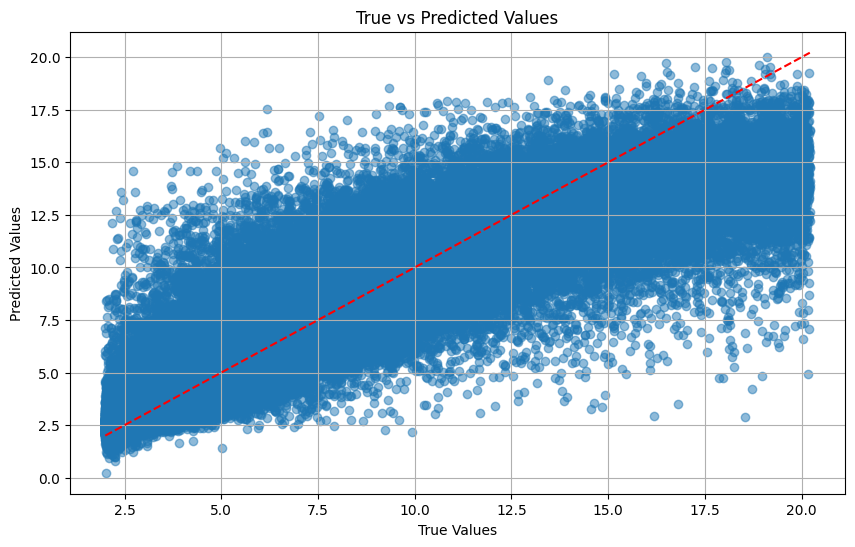

In [41]:
import matplotlib.pyplot as plt

# Assuming y_true_all and y_pred_all are defined and properly inverted

plt.figure(figsize=(10, 6))
plt.scatter(y_true_all, y_pred_all, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.plot([min(y_true_all), max(y_true_all)], [min(y_true_all), max(y_true_all)], color='red', linestyle='--') # Line of equality
plt.grid(True)
plt.show()


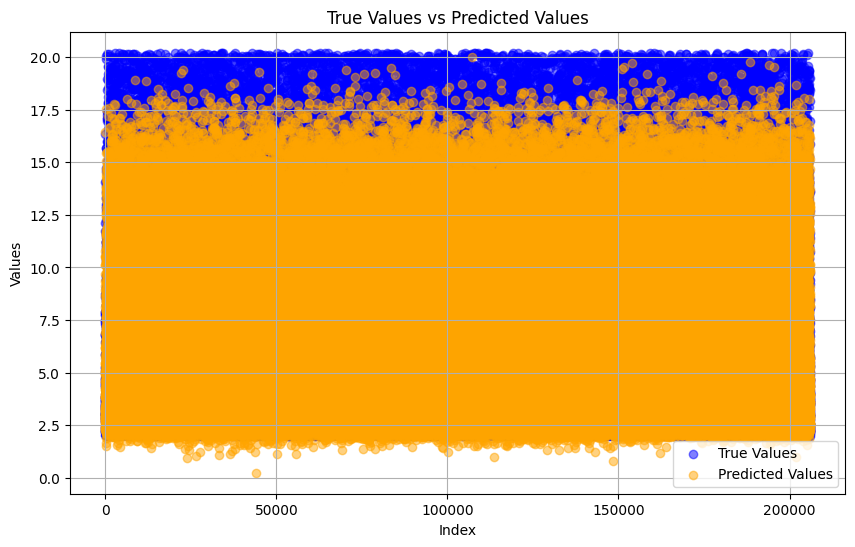

In [42]:
import matplotlib.pyplot as plt

# Example data for y_true_all and y_pred_all
# y_true_all = [your data here]
# y_pred_all = [your data here]

plt.figure(figsize=(10, 6))

# Plotting the true values
plt.scatter(range(len(y_true_all)), y_true_all, color='blue', alpha=0.5, label='True Values')

# Plotting the predicted values
plt.scatter(range(len(y_pred_all)), y_pred_all, color='orange', alpha=0.5, label='Predicted Values')

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('True Values vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


In [43]:
min_PT = min(y_true_all)
max_pT = max(y_true_all)

In [44]:
y_true_all = y_true_all.reshape(-1)
y_pred_all = y_pred_all.reshape(-1)

In [45]:
from scipy.stats import norm
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
import plotly.graph_objects as go
from scipy.optimize import curve_fit

In [46]:
def cuts(datain,datacheck,minval,maxval):
    dataout = datain[np.logical_and(datacheck > minval, datacheck < maxval)]
    
    return(dataout)

In [47]:
def plotgaussian(modelname, modelorreco, space, true, pred, varname, lower, upper, bins):
    resmeans = []
    stdevs = []
    bincenters = []
    samples = []
    
    #Compute residuals and bin width
    width = (upper - lower) / bins
    true = cuts(true, pred, lower, upper)
    pred = cuts(pred, pred, lower, upper)
    pred = cuts(pred, true, lower, upper)
    true = cuts(true, true, lower, upper)
    
    resids = true - pred
    
    #Create gaussian plot for each bin
    for i in range(bins):
        #Find bin dimensions
        lowertemp = lower + width * i
        uppertemp = lower + width * (i + 1)
        bincentertemp = (uppertemp + lowertemp) / 2
        
        #Cut the residuals to within lower and upper range along true values
        residscut = cuts(resids, 
                         true, 
                         lowertemp, 
                         uppertemp)
        
        varnametemp = '%s Residuals Distribution (%.2f to %.2f)' % (varname, 
                                                                    lowertemp, 
                                                                    uppertemp)
        residscut.sort()
        
        #Computer statistics for residuals
        resmeantemp, resstdtemp = norm.fit(residscut)
        samplestemp = len(residscut)
        pdf = stats.norm.pdf(residscut, resmeantemp, resstdtemp)
        
        #Plot histogram of residuals
        plt.hist(residscut, 
                 bins=bins, 
                 histtype='step', 
                 color='blue', 
                 density=1, 
                 label='Residuals')
        
        #Plot the normal curve fitted to the residuals
        plt.plot(residscut, 
                 pdf, 
                 label='Normal Curve', 
                 color='black')
        plt.title(varnametemp)
        
        #Plot the residuals mean as a vertical line
        plt.axvline(resmeantemp, 
                    label='Mean: %.2f' % resmeantemp, 
                    color='red')
        plt.xlabel('Stdev: %.2f (samples: %.i)' % (resstdtemp, 
                                                   samplestemp))
        
        #Plot the full-width half maximum range
        plt.axvspan(resmeantemp - resstdtemp / 2,
                    resmeantemp + resstdtemp / 2,
                    facecolor='g',
                    alpha=.3,
                    label='Stdev')        
        plt.legend()
        plt.savefig(f"{space}_gaussian.png", bbox_inches='tight')
#         plt.show()
        plt.close()
        
        #Append values to lists to be used by scatter() function
        resmeans.append(resmeantemp)
        samples.append(samplestemp)
        stdevs.append(resstdtemp)
        bincenters.append(bincentertemp)
    
    resmean = np.mean(resids)
    stddev = np.std(resids)    
    
    return resmeans, stdevs, bincenters, samples, resmean, stddev

In [48]:
model_name = "tabnet"

In [49]:
resmeans, fwhms, bincenters, samples, resmean, stddev = \
    plotgaussian(model_name, 
                 'Model', 
                 "/kaggle/working/", 
                 y_true_all, 
                 y_pred_all, 
                 'pT', 
                 min_PT, 
                 max_pT, 
                 100)

In [50]:
def heatmap(modelname, modelorreco, space, true, pred, varname, lower, upper, bins):

    heatmap, xedges, yedges = np.histogram2d(true, 
                                             pred, 
                                             bins=bins, 
                                             range=[[lower, upper], [lower, upper]])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    # Plot heatmap
    plt.imshow(heatmap.T, 
               extent=extent, 
               origin='lower')
    plt.plot([lower, upper], 
             [lower, upper], 
             color='blue')
    fig = plt.gcf()
    plt.set_cmap('gist_heat_r')
    plt.xlabel('%s True' % varname)
    plt.ylabel('%s Pred' % varname)
    plt.title('Frequency Heatmap')
    plt.xlim(lower, upper)
    plt.ylim(lower, upper)
    plt.colorbar()
    fig.savefig(f"{space}_heatmap_scaled.png")
    plt.show()
    plt.close()

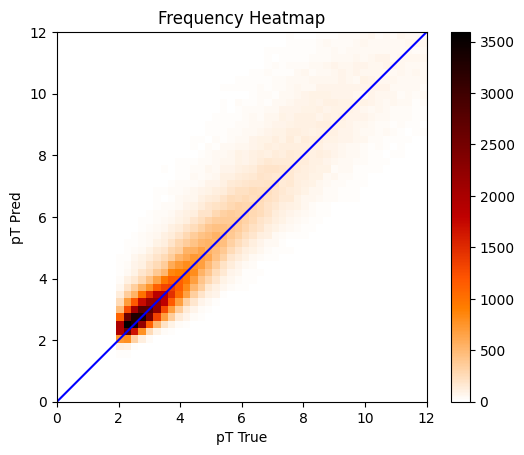

In [51]:
heatmap(model_name, 
            'Model', 
            "/kaggle/working/", 
            y_true_all, 
            y_pred_all, 
            'pT', 
            0, 
            12, 
            50)

In [52]:
# def scatter(modelname, space, metrics, bincenters, samples, varname, prednames, metricname):
#     bincenters = np.array(bincenters)
#     #Check that the bin centers match between the two datasets
#     if (np.std(bincenters[:,0]) > .0001) or (np.std(bincenters[:,-1]) > .0001):
#         print('Scatter plot failed due to different bincenters')
#         print(bincenters)
#         return
#     else:
#         #Create subplots for scatter and ratio
#         fig,axs = plt.subplots(2, gridspec_kw={'height_ratios':[3,1]})
#         axs[0].set_ylabel(metricname)
#         axs[0].set_title('Residuals %s vs %s' % (metricname,
#                                                 varname))
        
#         for i in range(len(prednames)):
#             #Find the width and range of bins
#             width = (bincenters[i][-1] - bincenters[i][-2]) / 2
#             lower = min(bincenters[i]) - width
#             upper = max(bincenters[i]) + width        

# #             if i == 0:
# #                   dif1 = np.abs(metrics[i])
# #             elif i == 1:
# #                   dif2 = np.abs(metrics[i])
                    
#             if i == 0:
#                   metric1 = np.array(metrics[i])
#             elif i == 1:
#                   metric2 = np.array(metrics[i])

#             print(np.shape(metrics))
#             #Create the scatterplot
#             axs[0].scatter(bincenters[i], 
#                            metrics[i], 
#                            label=prednames[i])
#             axs[0].axhline(y=0)


#             #Use standard error of the mean for y error and bin width for x error
#             axs[0].errorbar(bincenters[i],
#                             metrics[i],
#                             xerr=(bincenters[i][-1] - bincenters[i][-2]) / 2,
#                             yerr=metrics[i] / np.sqrt(samples[i]),
#                             linestyle='')
#         axs[0].legend()
#         axs[0].set_xlim([lower,upper])
        
# #         dif = dif1 - dif2
# #         #Create ratio subplot
# #         axs[1].scatter(bincenters[0], dif)
# #         axs[1].axhline(y=0)
# #         axs[1].set_xlim([lower, upper])
# #         axs[1].set_ylabel('|%s| - |%s|' % (prednames[0], prednames[1]))
# #         axs[1].set_xlabel('%s' % varname)
        
#         #Plot ratio subplot for first 2 data sets
#         axs[1].scatter(bincenters[i], metric1 / metric2)
#         axs[1].axhline(y=1)
#         axs[1].set_xlim([lower,upper])
#         axs[1].set_ylim([0.5,2.0])
#         axs[1].set_yscale('log', basey=2)
#         axs[1].set_ylabel('%s / %s' % (prednames[0],
#                                        prednames[1]))
#         axs[1].set_xlabel('%s' % varname)
        
#         #Save plot
#         fig.savefig('./Plots/%s/Comparison/%s/%s_%s_scatter' % (modelname, 
#                                                                 space,
#                                                                 varname,
#                                                                 metricname), bbox_inches='tight')
#         plt.close()

In [53]:
inputs = torch.randn((1, 16)).to(device) # change to whatever the data shape is for what you use here
# model = ...
# profile_model(regressor.predict, inputs, 1000)